# Forecasting temperature with SARIMA


## Introduction

> Weather forecasting is a difficult but important task. All predictions have a degree of uncertainty, but the chaotic character of our atmosphere causes weather forecasting to become especially challenging. As you might have experienced yourself, day-to-day weather prediction becomes unreliable more than a week into the future. 

The aim for this project is to find an appropriate model able to forecast monthly mean air temperature in Stockholm. 



https://irjabs.com/files_site/paperlist/r_449_121110152548.pdf

http://www.statistics.du.se/essays/D09_Xier_Li.pdf

http://www.statistics.du.se/essays/D08D_XiangJunquan.pdf

In [3]:
library(plotly);
library(ggplot2);
library(ggfortify);
library(repr);
library(tidyr);
library(tsibble);
library(TSstudio);
library(zoo);
library(dplyr);
library(tseries)
library(forecast);

library(ggridges)
library(viridis)
library(hrbrthemes)
library(heatmaply)

Sys.setlocale(locale = "English");
windowsFonts(Times=windowsFont("Times New Roman"));

options(repr.plot.width=14, repr.plot.height=8)
IRdisplay::display_html('<style>.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}</style>')

th <- theme(text=element_text(size = 20, face = "bold",  family="Times"),
        plot.title = element_text(size = 25, face = "bold",  family="Times", hjust = 0.5),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid = element_line(size = 0.25, linetype = 'solid',
                                colour = "grey80"))

Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout



Attaching package: 'tsibble'


The following objects are masked from 'package:base':

    intersect, setdiff, union



Attaching package: 'zoo'


The following object is masked from 'package:tsibble':

    index


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method                 from     
  autoplot.Arima         ggfortify
  aut

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

https://bolin.su.se/data/stockholm-historical-monthly-temperature-3?n=stockholm-historical-temps-monthly-3

## Models

The autoregressive moving-average (ARMA) process is an fundamental parametric family of stationary time series. If selected time series (i) does not exhibit evidence against stationarity and (ii) rapidly decreasing autocovariance function, an ARMA could potentially be fitted to the mean-corrected data. Otherwise, considering autoregressive integrated moving-average (ARIMA) can prove to be wise. For a time series {$X_t$}, SARIMA is defined as

$$
\phi(B)(1-B)^d X_t = \theta(B)Z_t, \quad {Z_t} \sim WN(0, \sigma^2)
$$
where $\phi(z)$ and $\theta(z)$ are a

If the time series has an apparent seasonal component, seasonal ARIMA (SARIMA) becomes a valid option. 

Finding an appropriate model for non-stationary time series require the use of autoregressive integrated moving-average (ARIMA). 

## Data source
The data consist out of 36 years of monthly mean air temperatures. 

In [4]:
train_df <- read.csv("dataset/train_stockholm_monthly_mean_temperature.csv", sep=';')
test_df <- read.csv("dataset/test_stockholm_monthly_mean_temperature.csv", sep=';')
df <- rbind(train_df, test_df)
head(df)

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,-4.7,-6.2,-3.1,4.8,7.8,15.6,16.8,14.6,12.8,5.7,0.0,-0.8
2,1981,-4.0,-2.7,-2.2,3.9,10.8,12.6,16.4,14.6,11.7,6.5,1.1,-5.7
3,1982,-7.2,-4.0,1.1,4.1,9.4,12.5,17.4,17.0,12.3,7.6,4.5,0.3
4,1983,0.7,-3.8,-0.1,4.0,10.2,14.0,18.0,17.8,12.4,7.5,1.2,-1.1
5,1984,-3.0,-1.7,-2.0,5.3,10.9,13.3,15.3,16.4,10.6,8.9,4.3,0.8
6,1985,-9.0,-11.6,-1.7,1.6,9.0,13.6,15.9,15.4,10.3,8.0,0.3,-4.3


In [5]:
train <- ts(as.vector(t(as.matrix(train_df[,-1]))), start=c(min(train_df$year), 1), 
            end=c(max(train_df$year), 12), frequency =12)

df_ts <- ts(as.vector(t(as.matrix(df[,-1]))), start=c(1980, 1), 
            end=c(2020, 12), frequency =12)

# Reshaped version for visualization
train_reshape <- data.frame(date=as.Date(as.yearmon(time(train))), temp=as.matrix(train))
train_reshape$month <- format(train_reshape$date, "%b")
train_reshape$year <- format(train_reshape$date, "%Y")

head(train_reshape)

,date,temp,month,year
,<date>,<dbl>,<chr>,<chr>
1,1980-01-01,-4.7,Jan,1980
2,1980-02-01,-6.2,Feb,1980
3,1980-03-01,-3.1,Mar,1980
4,1980-04-01,4.8,Apr,1980
5,1980-05-01,7.8,May,1980
6,1980-06-01,15.6,Jun,1980


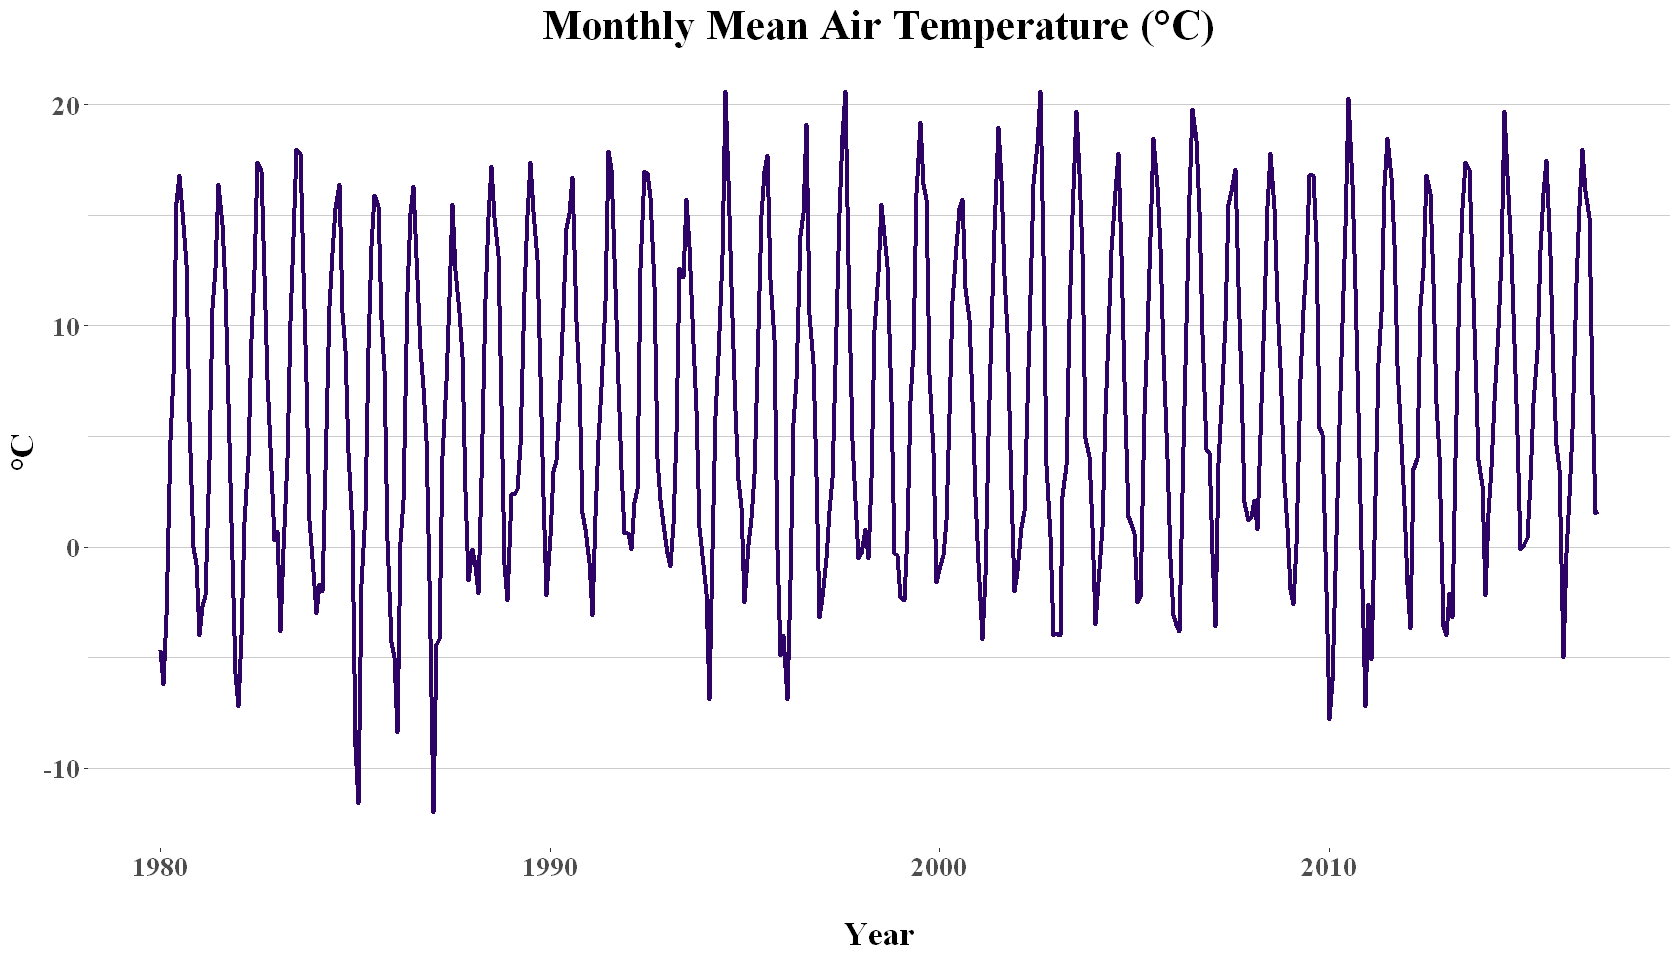

In [6]:
ggplot(data=train_reshape, aes(x=date, y=temp, group=1))+
    ggtitle("Monthly Mean Air Temperature (°C)")+
    geom_line(color="#2d0365", size=1.2)+
    xlab("\nYear") + ylab("°C") +
    th + theme(legend.position="none")

> Ridgeline plot. Potential outliers in January and February. 

Picking joint bandwidth of 0.787



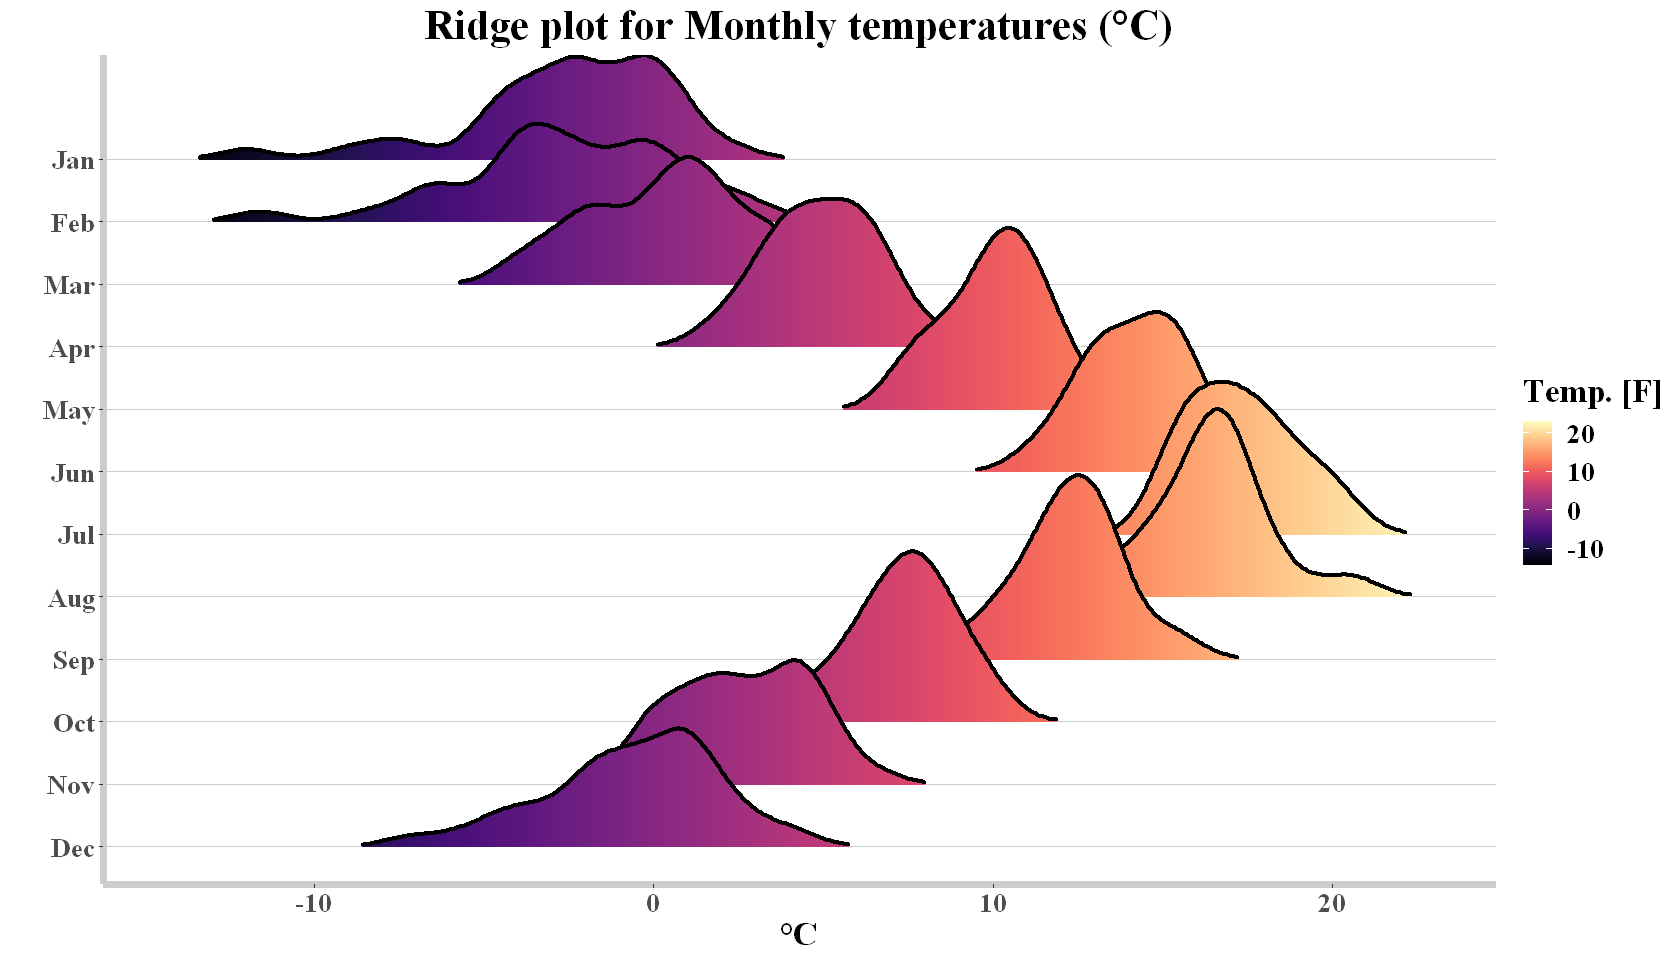

In [7]:
ggplot(train_reshape, aes(x = temp, y = factor(month, levels = month.abb), fill = ..x..))+
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01, lwd=1.2) +
    scale_fill_viridis(name = "Temp. [F]", option = "A") +
    labs(title = 'Ridge plot for Monthly temperatures (°C)') +
    scale_y_discrete(limits=rev) +
    xlab("°C") + ylab("") +
    th + theme(axis.line = element_line(size = 2, colour = "grey80"))

Outliers are better visualised through a boxplot. From both the ridge plot and boxplot, it appears is if the variance is not consistent over months.

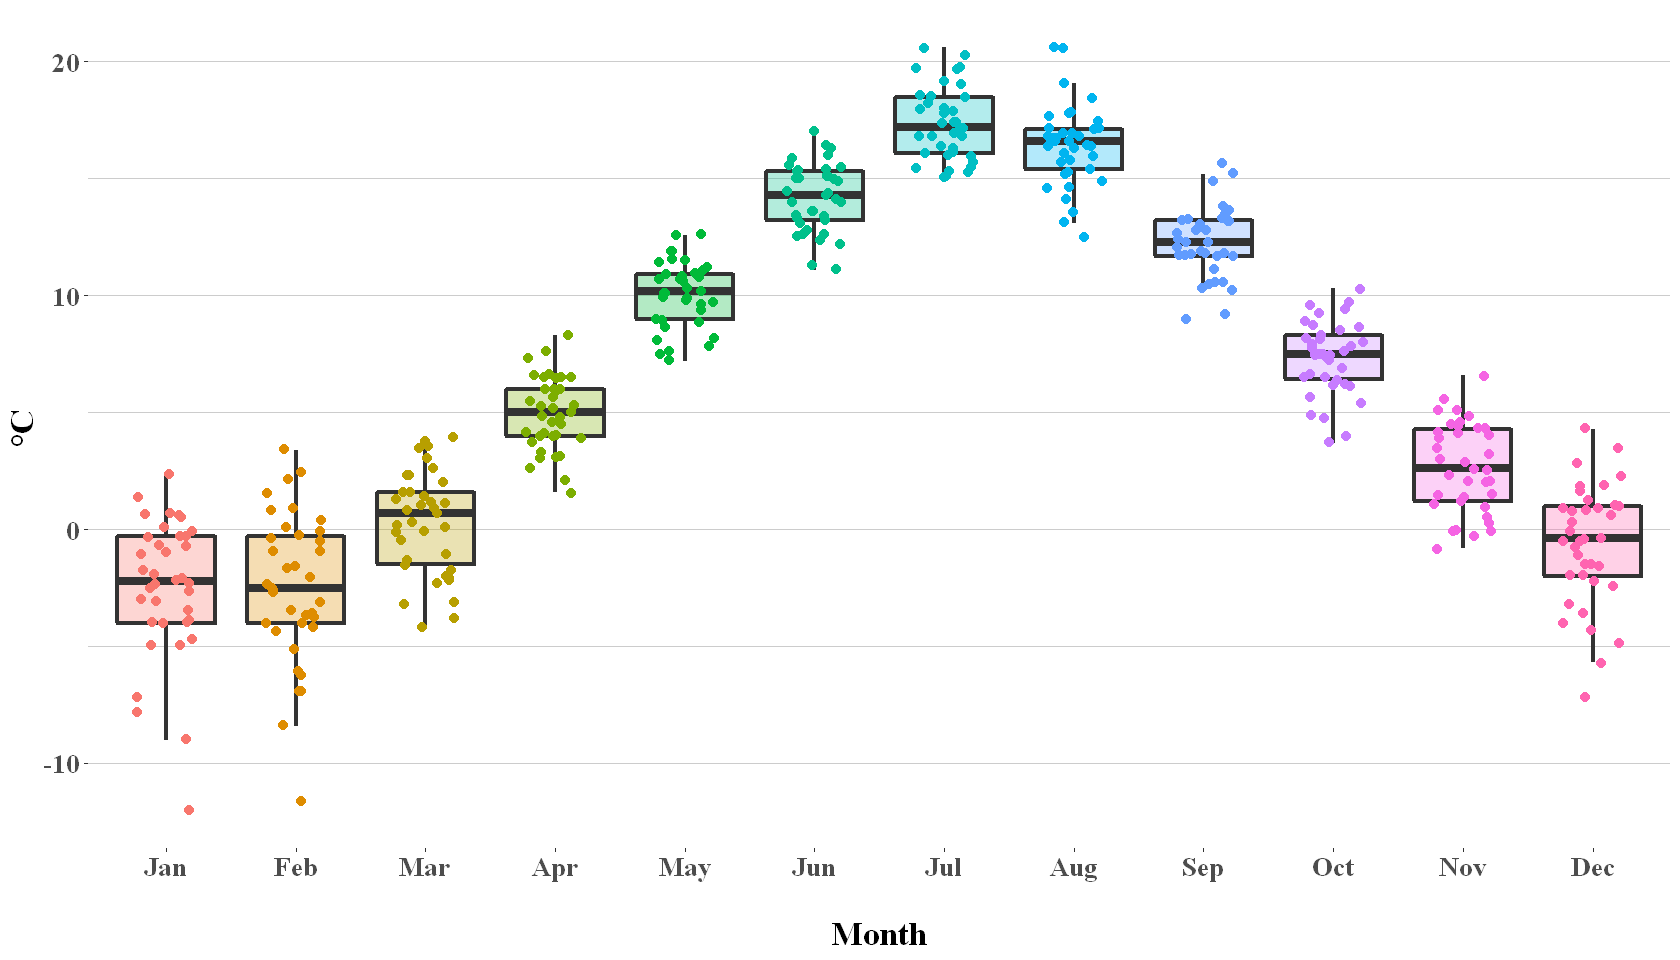

In [8]:
ggplot(train_reshape, aes(x = factor(month, levels = month.abb), y = temp, fill=factor(month, levels = month.abb)))+
    geom_boxplot(outlier.alpha = 0, alpha=0.3, lwd=1.2) +
    geom_jitter(size=2.4, position=position_jitter(0.23), aes(colour=factor(month, levels = month.abb)))+ 
    xlab("\nMonth") + ylab("°C") +
    th + theme(legend.position="none")

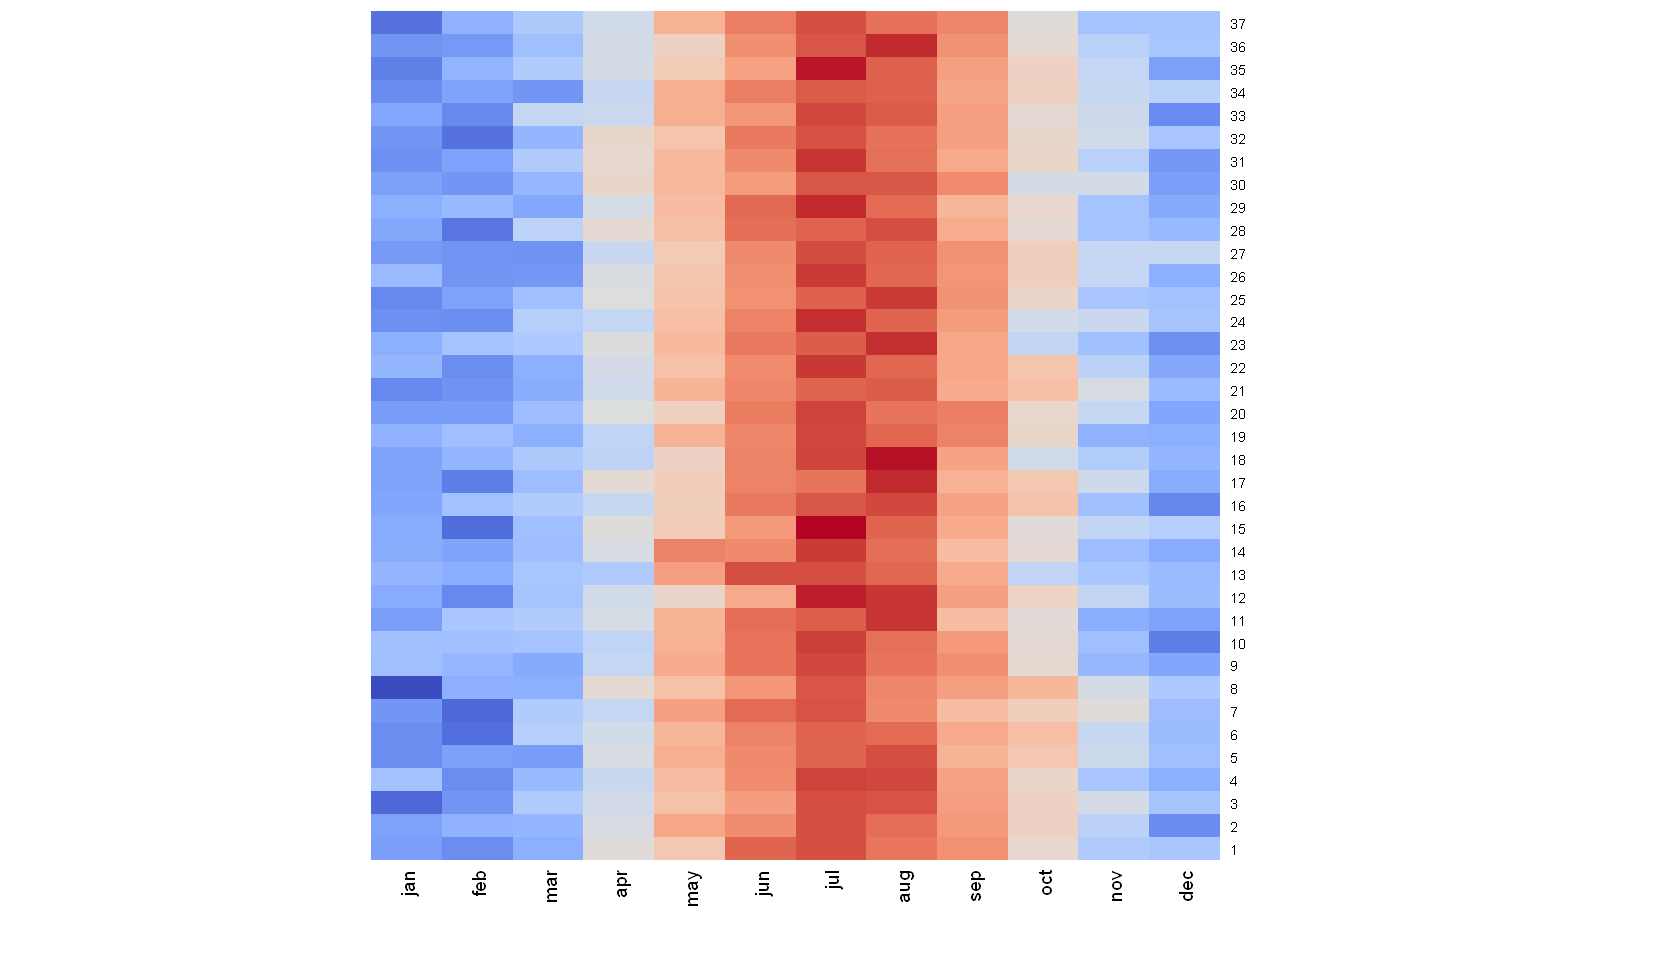

In [9]:
dt <- as.matrix(train_df[,-1])
heatmap(dt, Colv =NA, Rowv =NA, col=cool_warm(256))

A good way of visualising seasonal changes through time is a seasonal subseries plot.

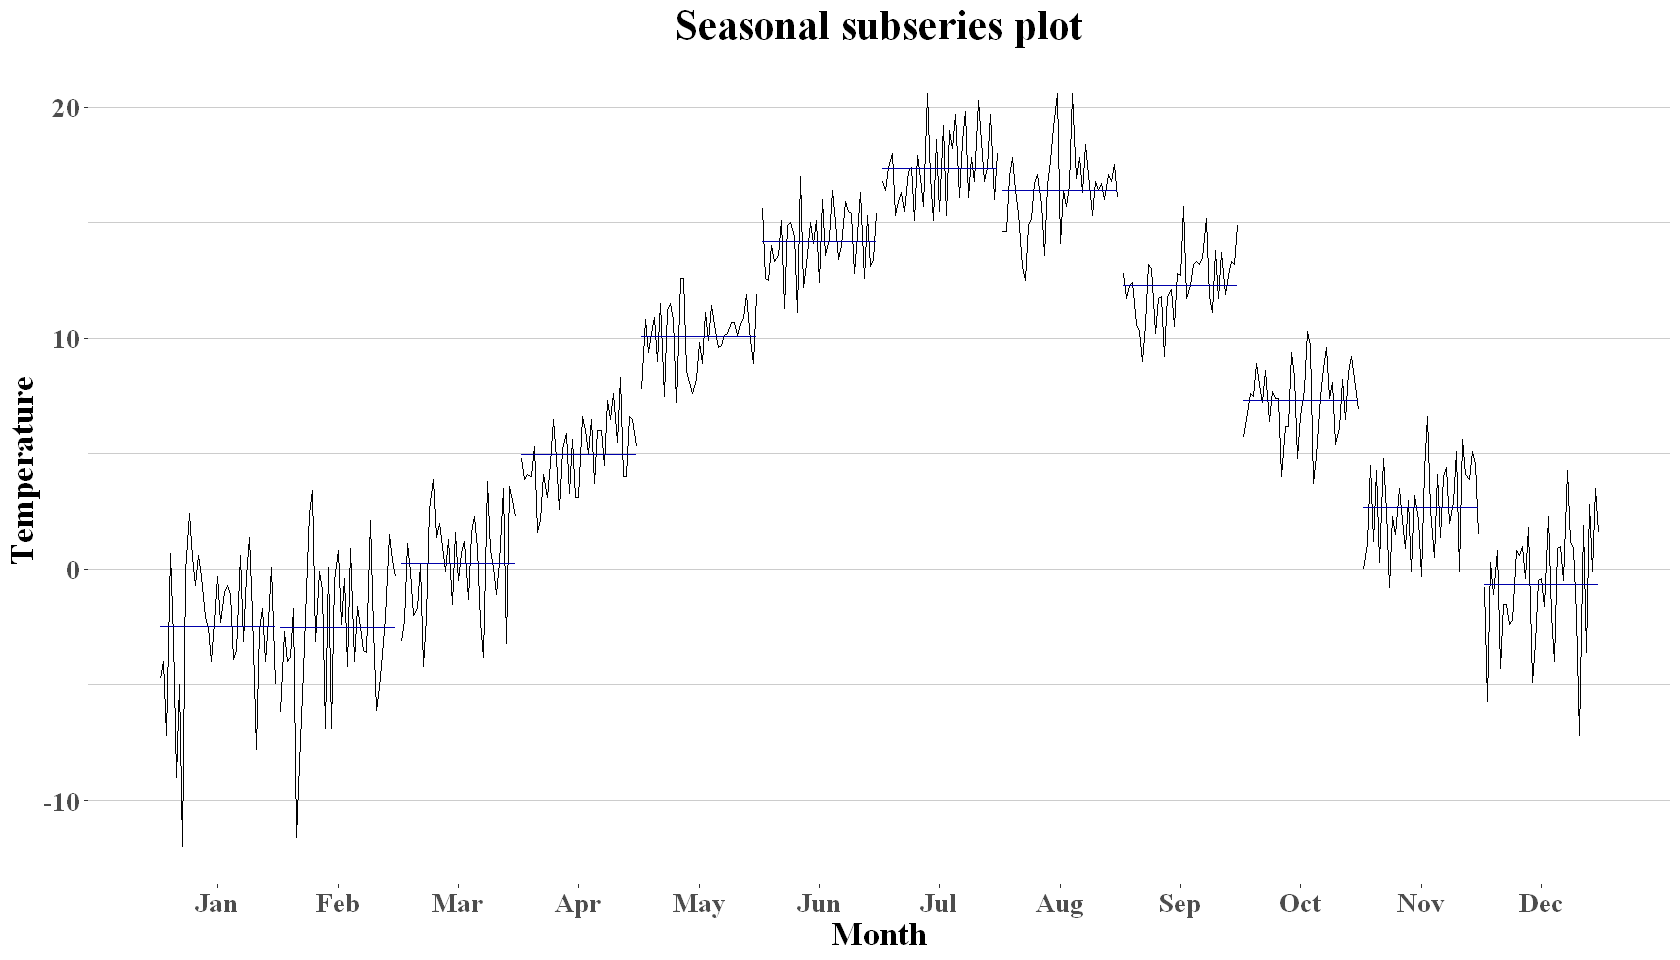

In [10]:
ggsubseriesplot(train) +
    ylab("Temperature") +
    ggtitle("Seasonal subseries plot") +
    th

In [11]:
max(train_df$year)

[1] 2016

### What to do next?

Our data set has problematic characeristics which can not be captured by any ordinary ARIMA model. The change in variance and 

In [78]:
train_short <- ts(as.vector(t(as.matrix(train_df[,-1]))), start=c(2007, 1), 
            end=c(max(train_df$year), 12), frequency =12)

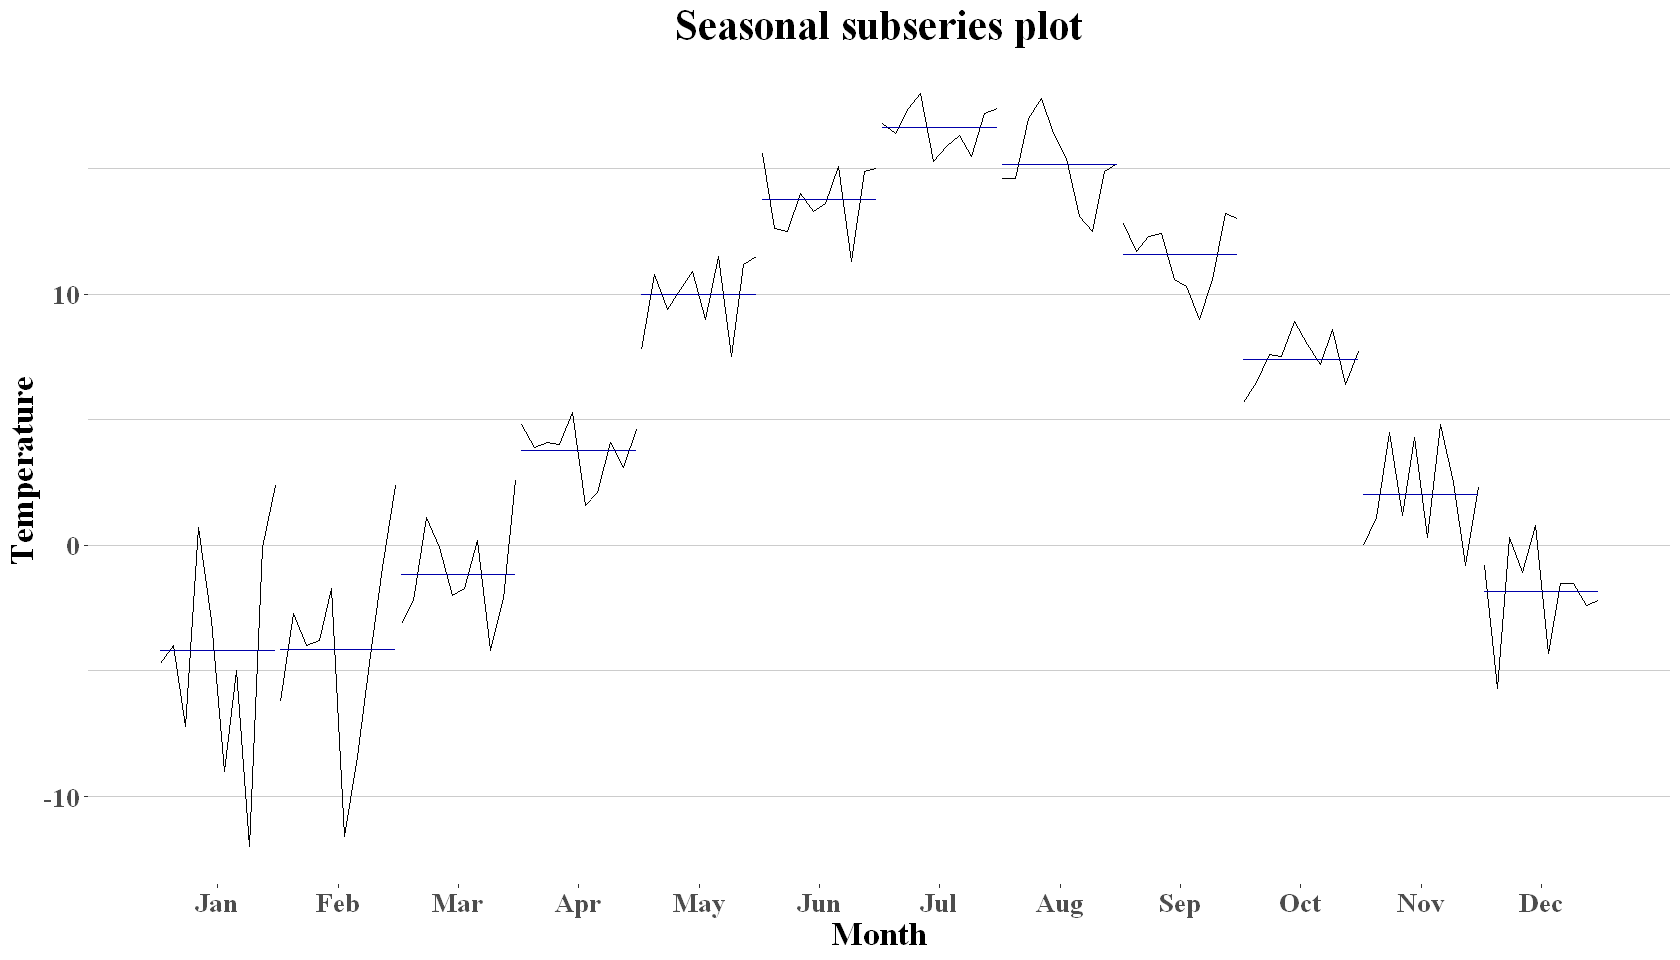

In [79]:
ggsubseriesplot(train_short) +
    ylab("Temperature") +
    ggtitle("Seasonal subseries plot") +
    th

### Transformation

In [93]:
min(as.vector(t(as.matrix(train_df[,-1]))))

[1] -12

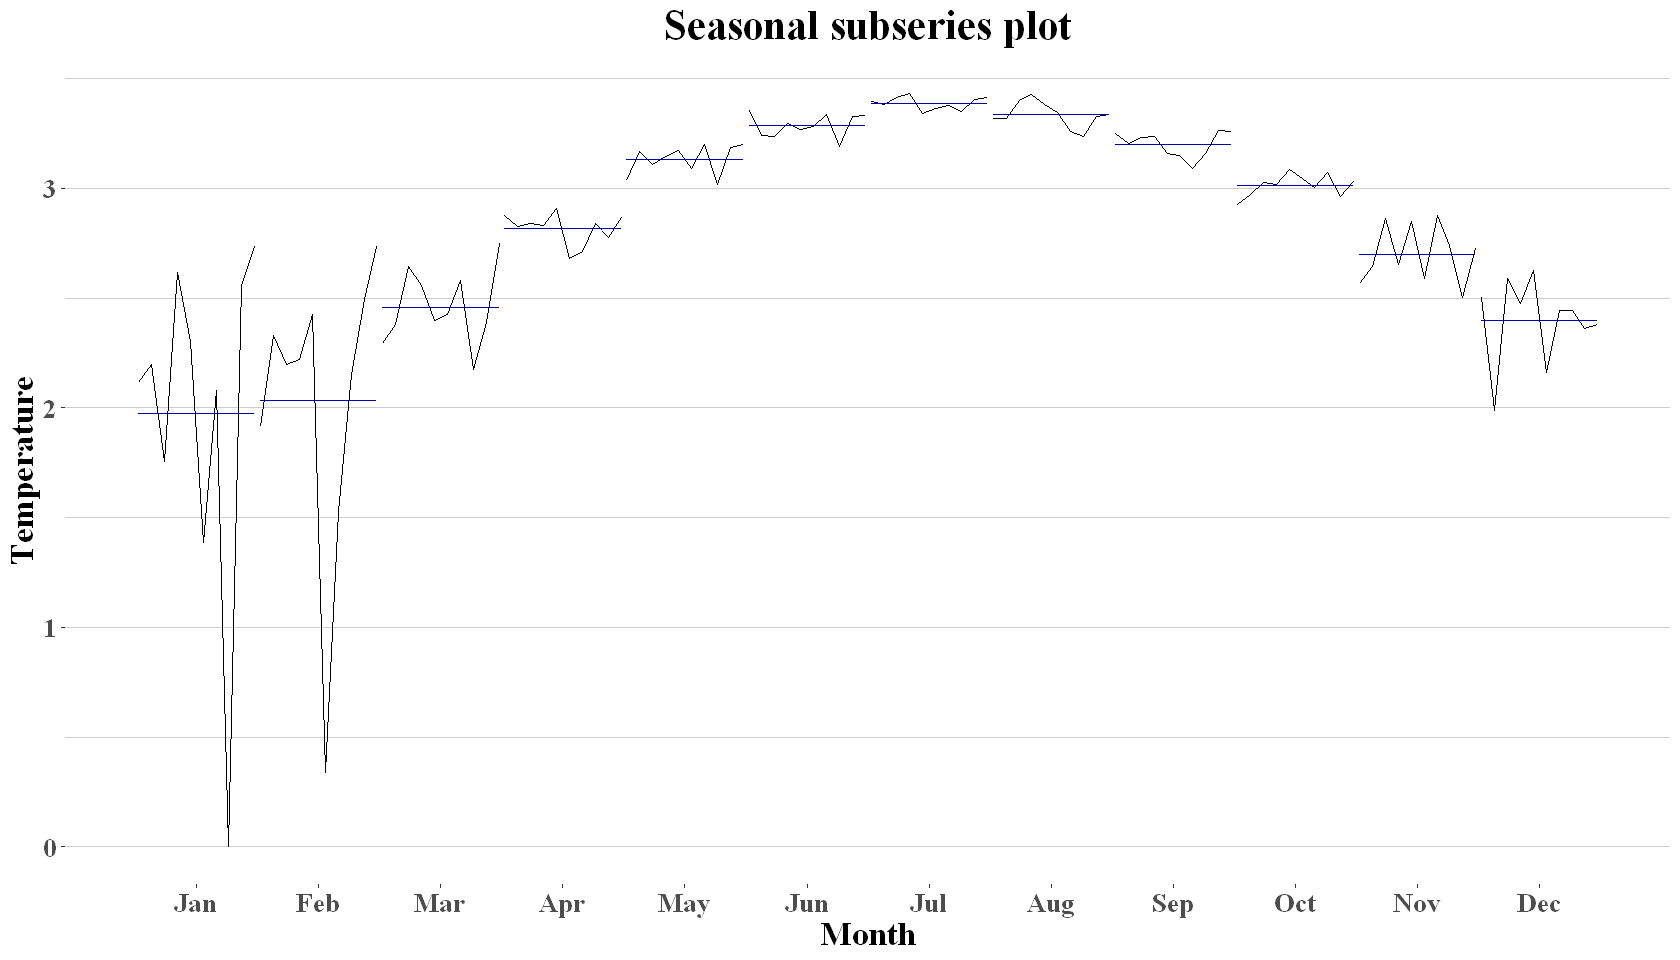

In [96]:
a = 1 - min(as.vector(t(as.matrix(train_df[,-1]))))

train_log <- ts(log(as.vector(t(as.matrix(train_df[,-1])))+a), start=c(2007, 1), 
            end=c(max(train_df$year), 12), frequency =12)

ggsubseriesplot(train_log) +
    ylab("Temperature") +
    ggtitle("Seasonal subseries plot") +
    th

For example, a root near 1 of the autoregressive polynomial suggests that the data
should be differenced before fitting an ARMA model, whereas a root near 1 of
the moving-average polynomial indicates that the data were overdifferenced.

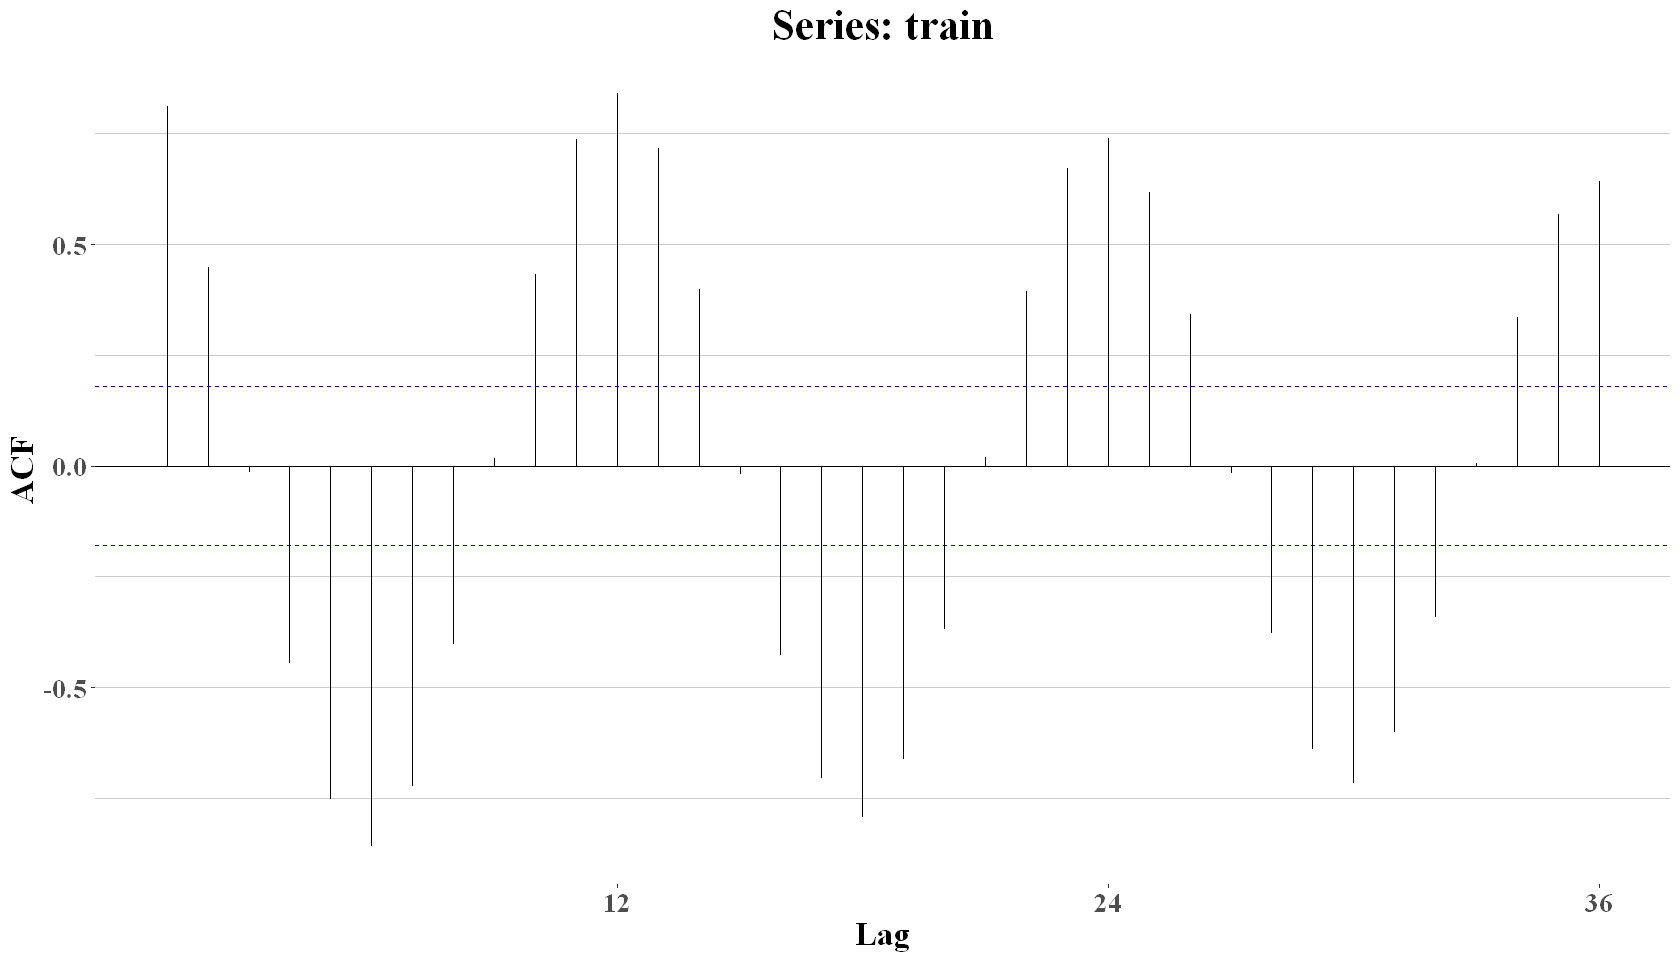

In [63]:
ggAcf(train, lag.max = 36) +
    th

If the magnitude of seasonal fluctuations does not vary with level of time series, the addative model is sufficient. 

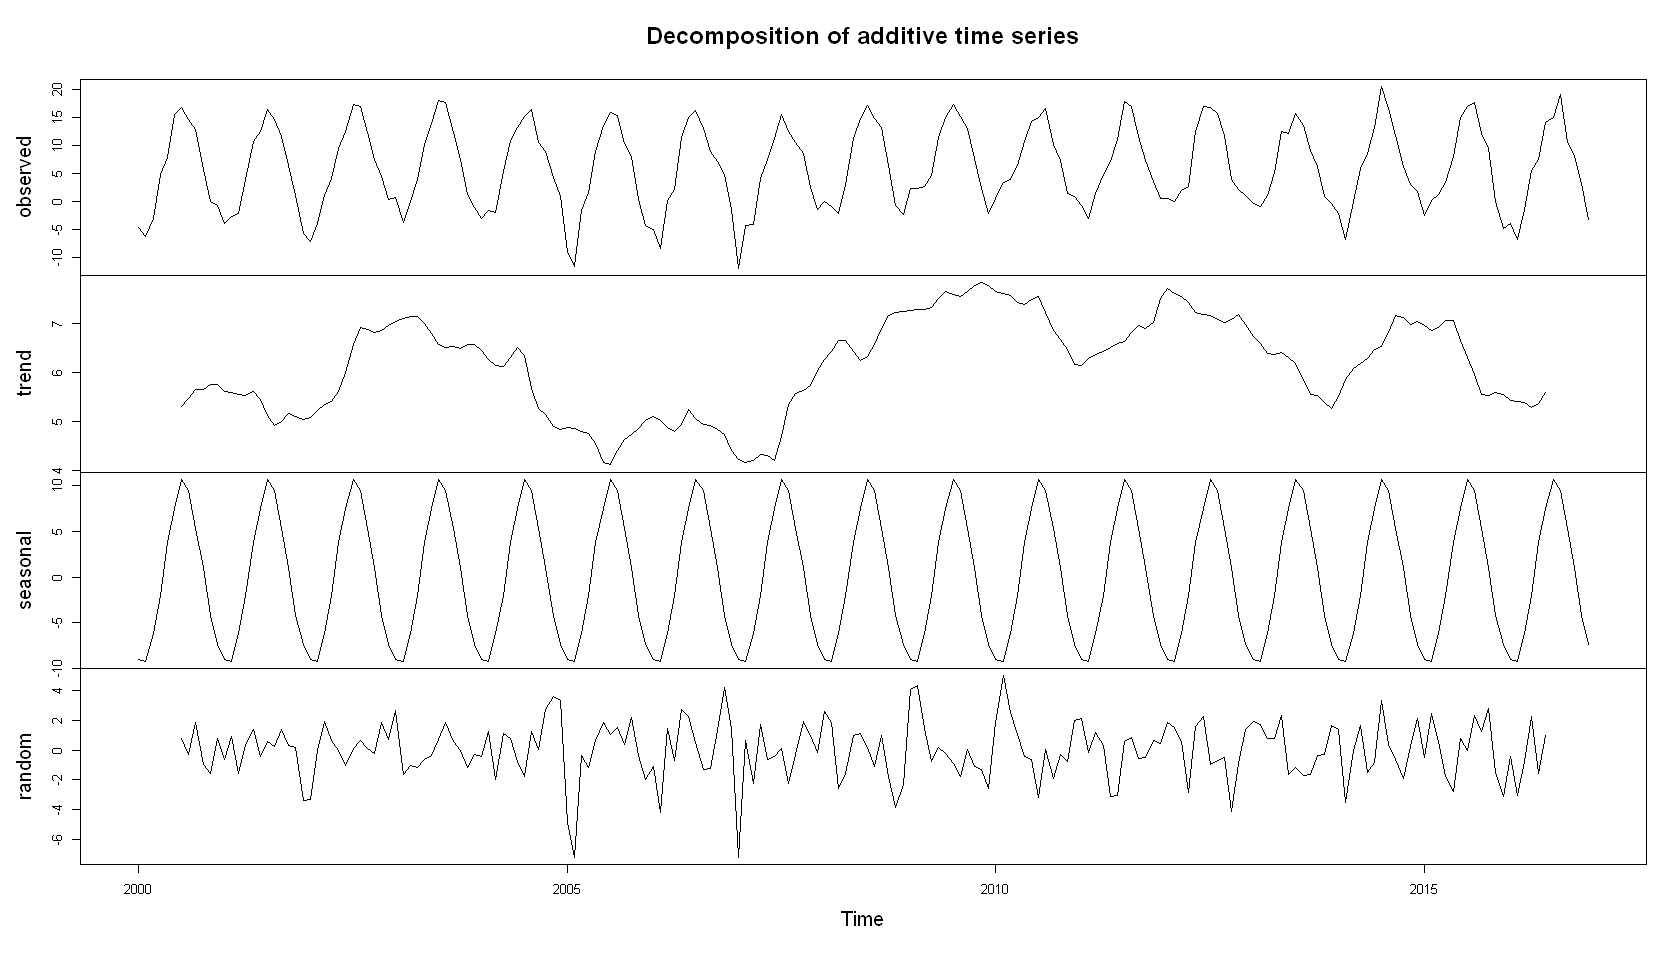

In [49]:
decomp = decompose(train)
plot(decomp)

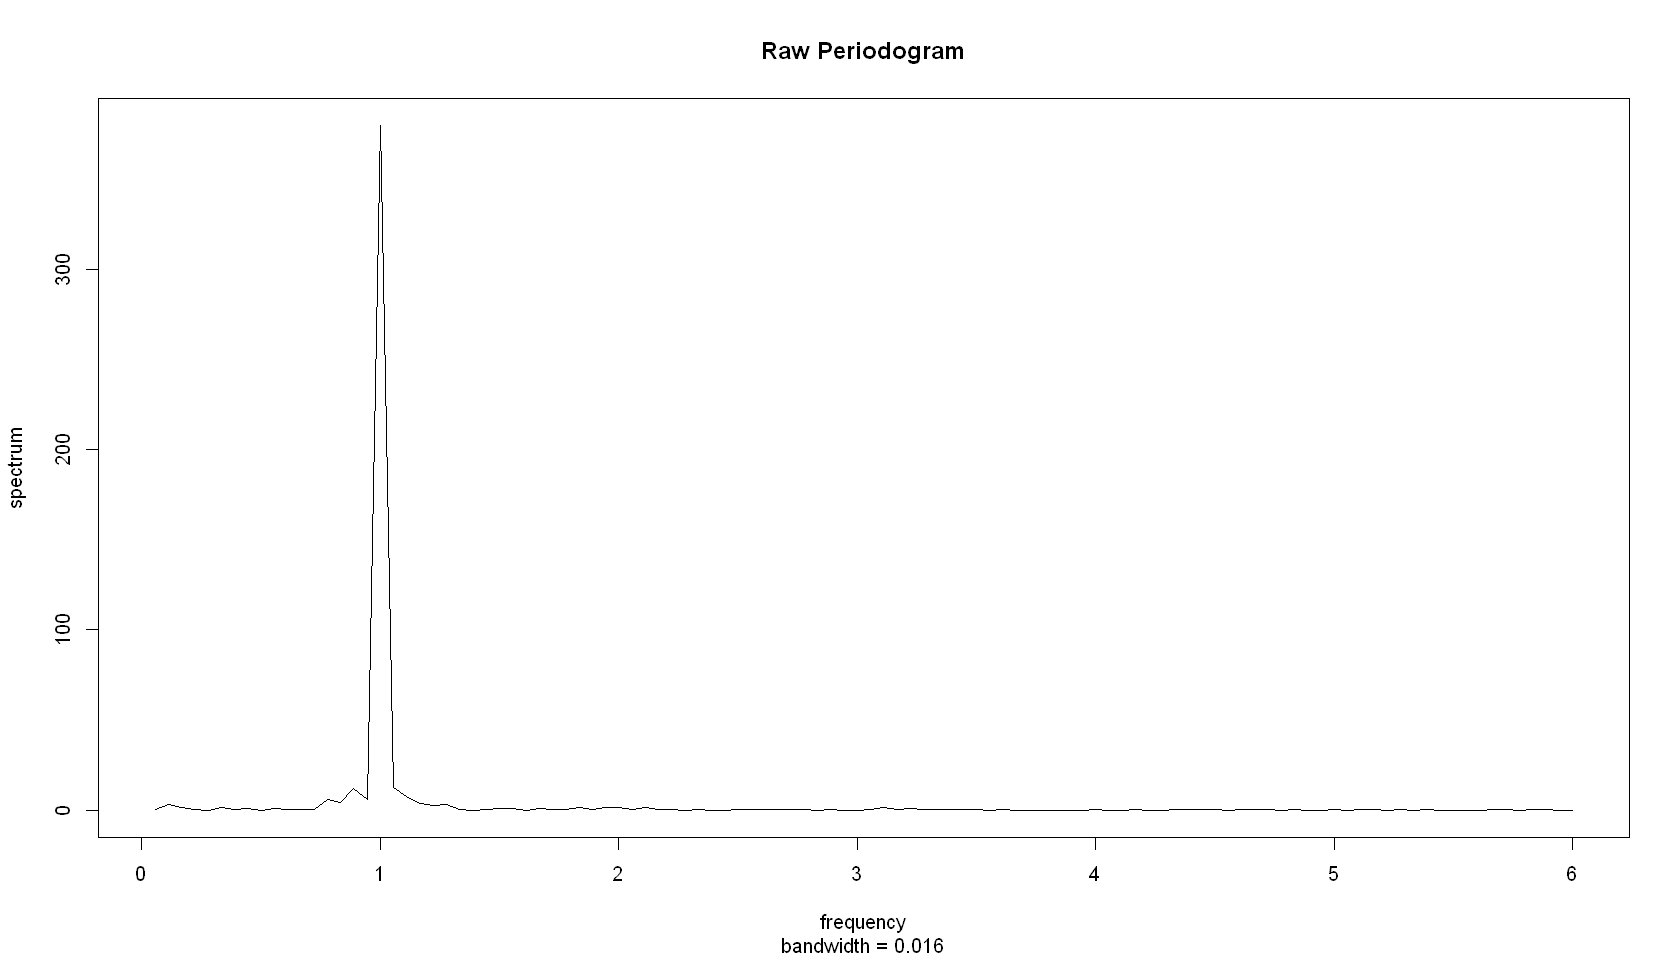

In [50]:
spec.pgram(train, log="no", main="Raw Periodogram")

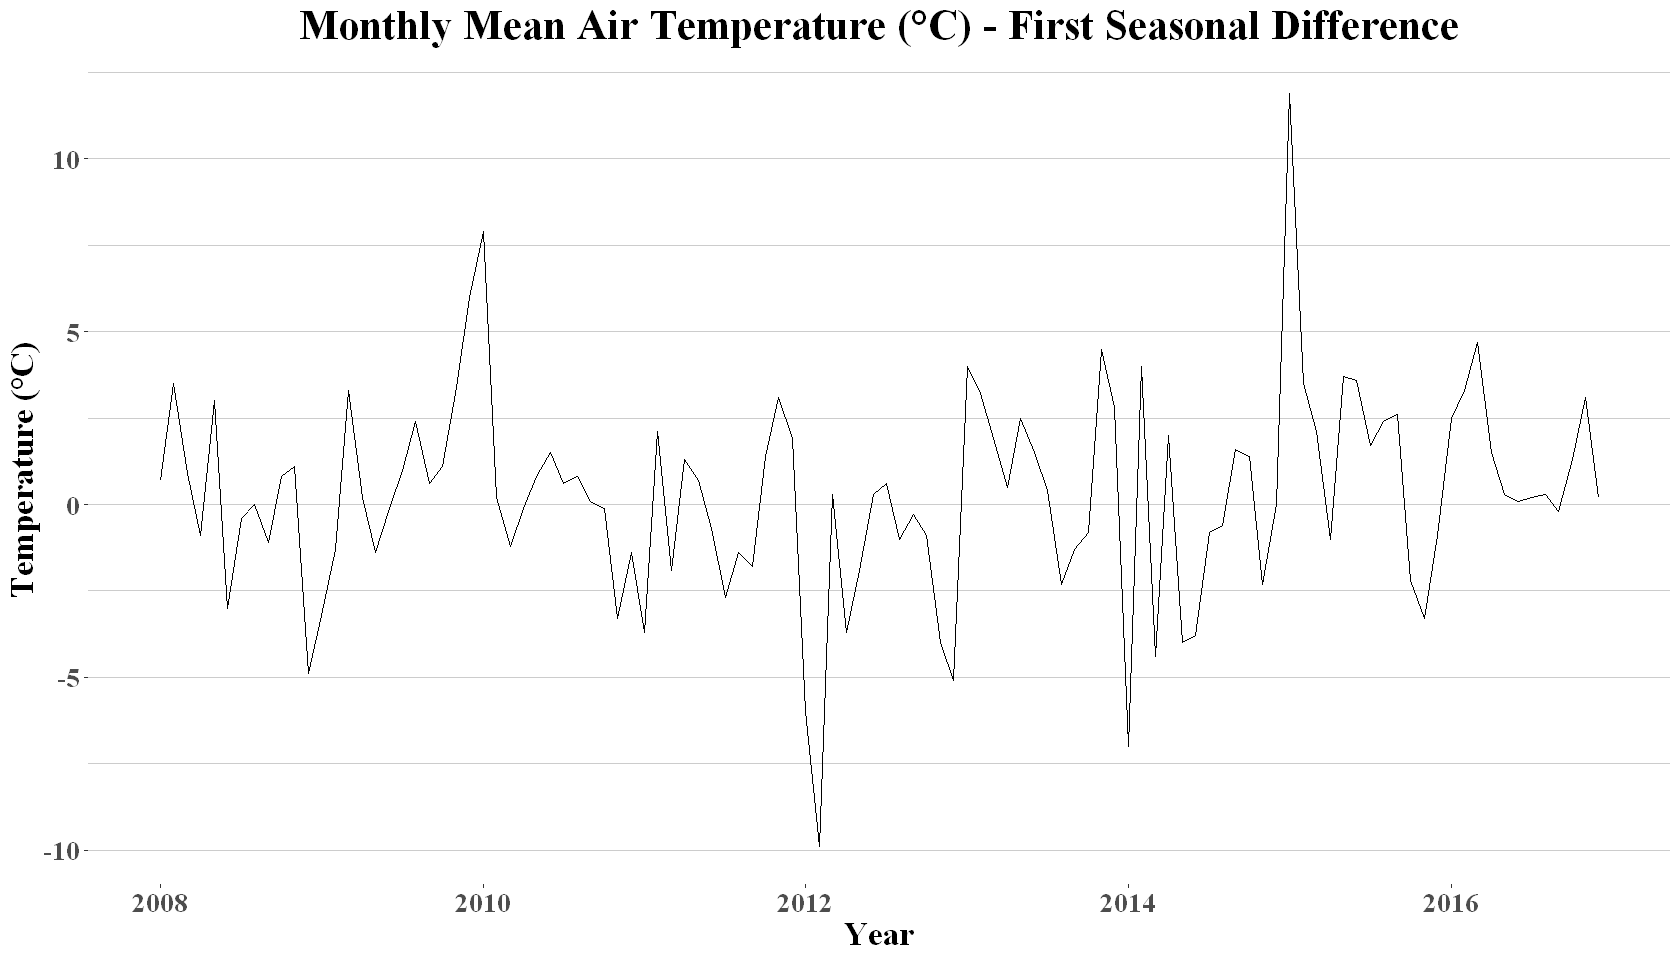

In [64]:
# Seasonal difference
train.diff = diff(train, lag=12)
autoplot(train.diff, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("Monthly Mean Air Temperature (°C) - First Seasonal Difference")+ 
    th + 
    guides(colour = guide_legend(title.hjust = 20))

**Augmented Dicker-Fuller test**. 

Rejection of null hypotheisis, evidence of stationarity. It should be notet however most unit root tests does have a high type 1 error rate, that is incorrect rejection of a true null hypothesis.

In [65]:
adf.test(train.diff)


	Augmented Dickey-Fuller Test

data:  train.diff
Dickey-Fuller = -3.9344, Lag order = 4, p-value = 0.015
alternative hypothesis: stationary


**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**.
Check if time series is stationary around a deterministic trend. Presence of unit root is not the null hypothesis but rather the alternative.

In [66]:
kpss.test(train.diff)

Warning message in kpss.test(train.diff):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  train.diff
KPSS Level = 0.19337, Truncation lag parameter = 4, p-value = 0.1


In [19]:
library(gridExtra)


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




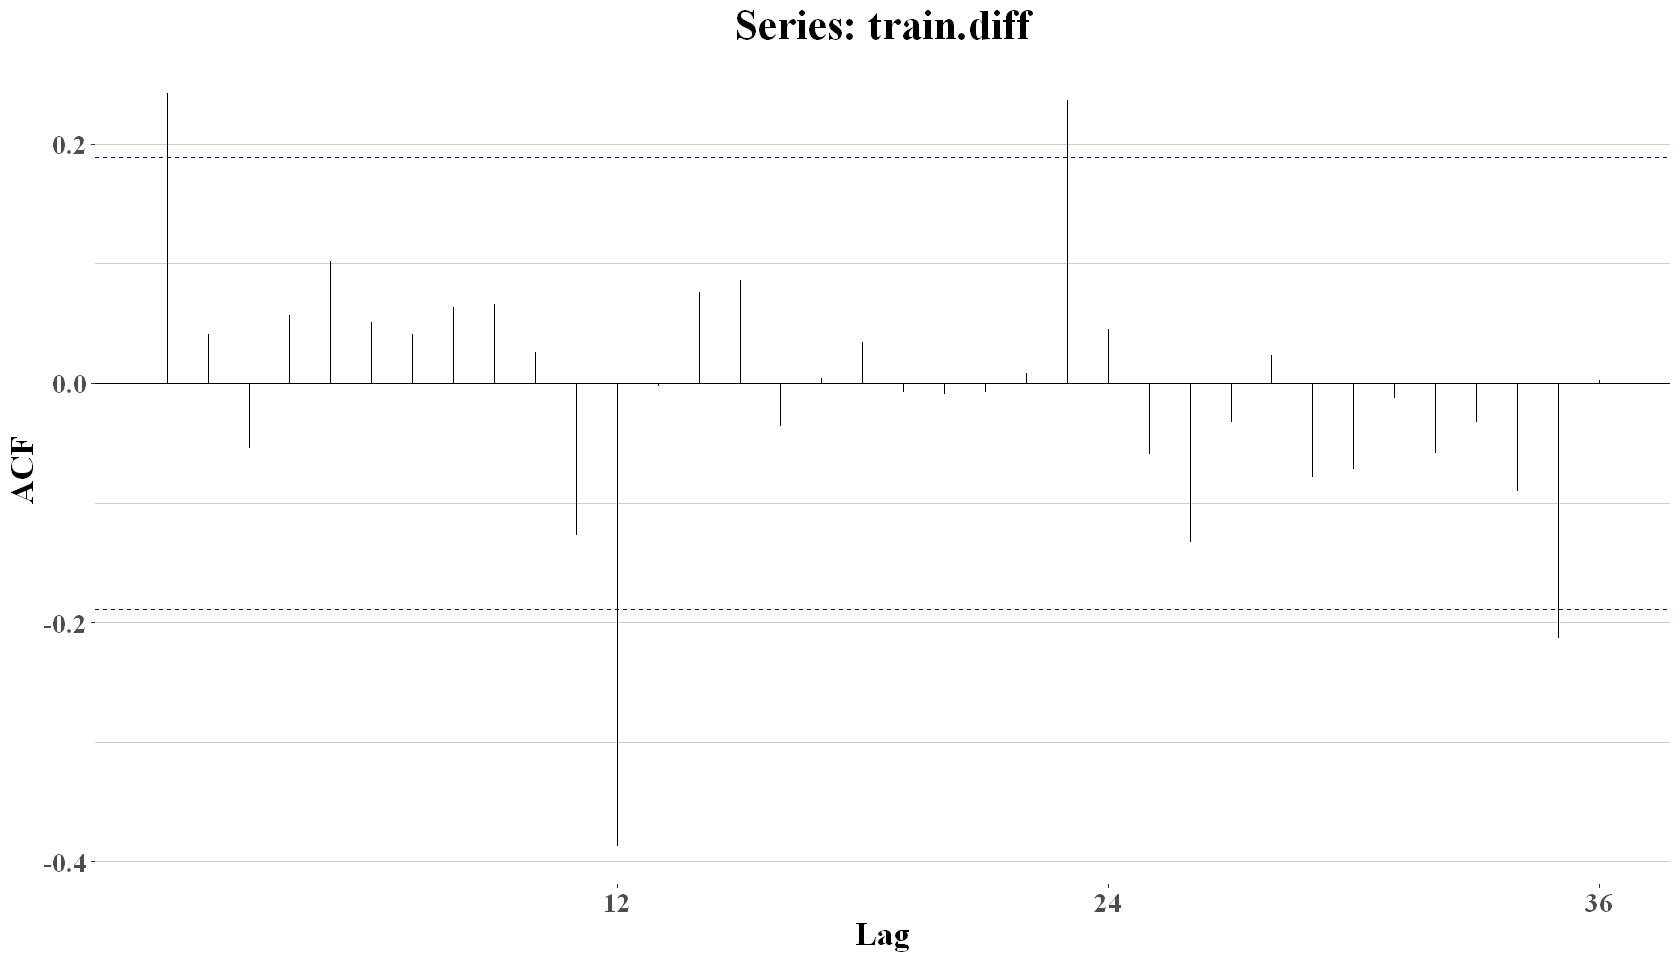

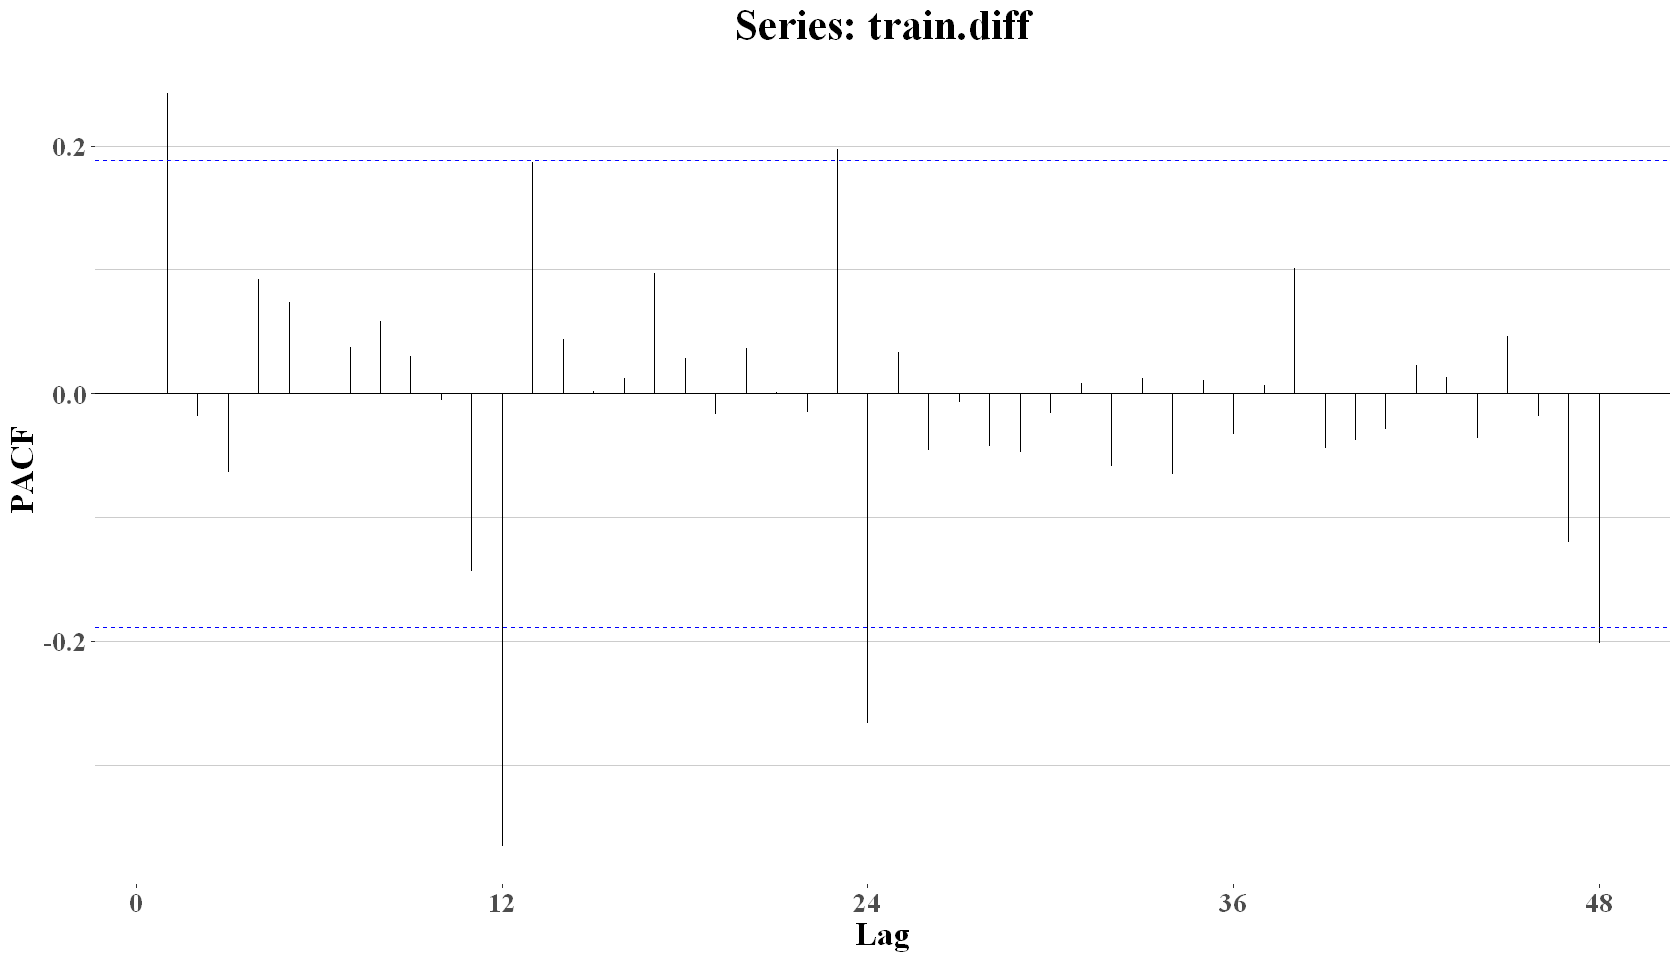

In [67]:

ggAcf(train.diff, lag.max = 36) +
    th

ggPacf(train.diff, lag.max = 48) +
    th

In [68]:
p <- q <- P <- Q <- 0:3
grid <- expand.grid(p=p, q=q, P=P, Q=Q)
grid$k <- rowSums(grid)
grid <- grid %>% filter(k<=4)

arima_search <- lapply(1:nrow(grid), function(i){
    mdl <- NULL
    mdl <- try(arima(train, order=c(grid$p[i], 0, grid$q[i]), 
                     seasonal=list(order=c(grid$P[i], 1, grid$Q[i]), period=12)))
    
    aic_scores <- data.frame(p = grid$p[i], d=0, q=grid$q[i], P=grid$P[i], D=1, Q=grid$Q[i], AIC = mdl$aic)
}) %>% bind_rows() %>% arrange(AIC)

head(arima_search)

,p,d,q,P,D,Q,AIC
,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1,0,0,1,1,2,499.9624
2,1,0,0,0,1,1,500.1006
3,0,0,1,1,1,2,500.5375
4,0,0,1,0,1,3,500.6511
5,1,0,0,0,1,3,501.0039
6,0,0,1,0,1,1,501.2716


# Residual Check


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0)(1,1,2)[12]
Q* = 12.552, df = 20, p-value = 0.8958

Model df: 4.   Total lags used: 24



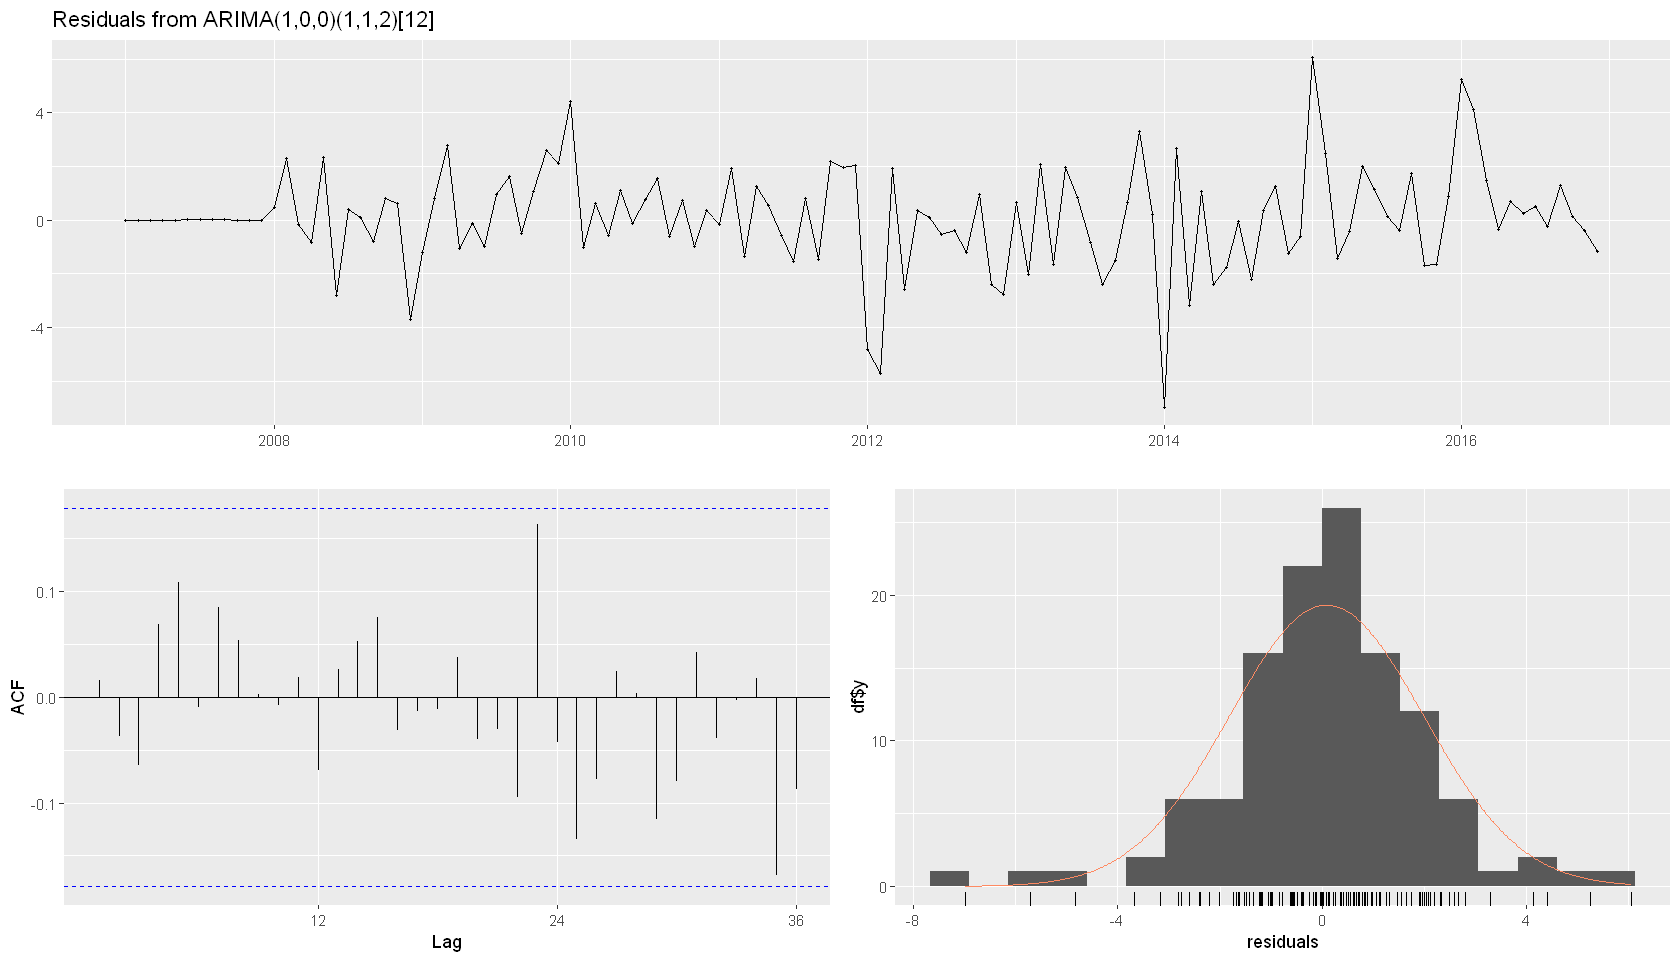

In [73]:
mdl <- arima(train, order = c(1, 0, 0), seasonal=list(order=c(1,1,2)))
checkresiduals(mdl)

In [74]:
Box.test(mdl$residuals)


	Box-Pierce test

data:  mdl$residuals
X-squared = 0.029949, df = 1, p-value = 0.8626



	Shapiro-Wilk normality test

data:  mdl$residuals
W = 0.96215, p-value = 0.001889


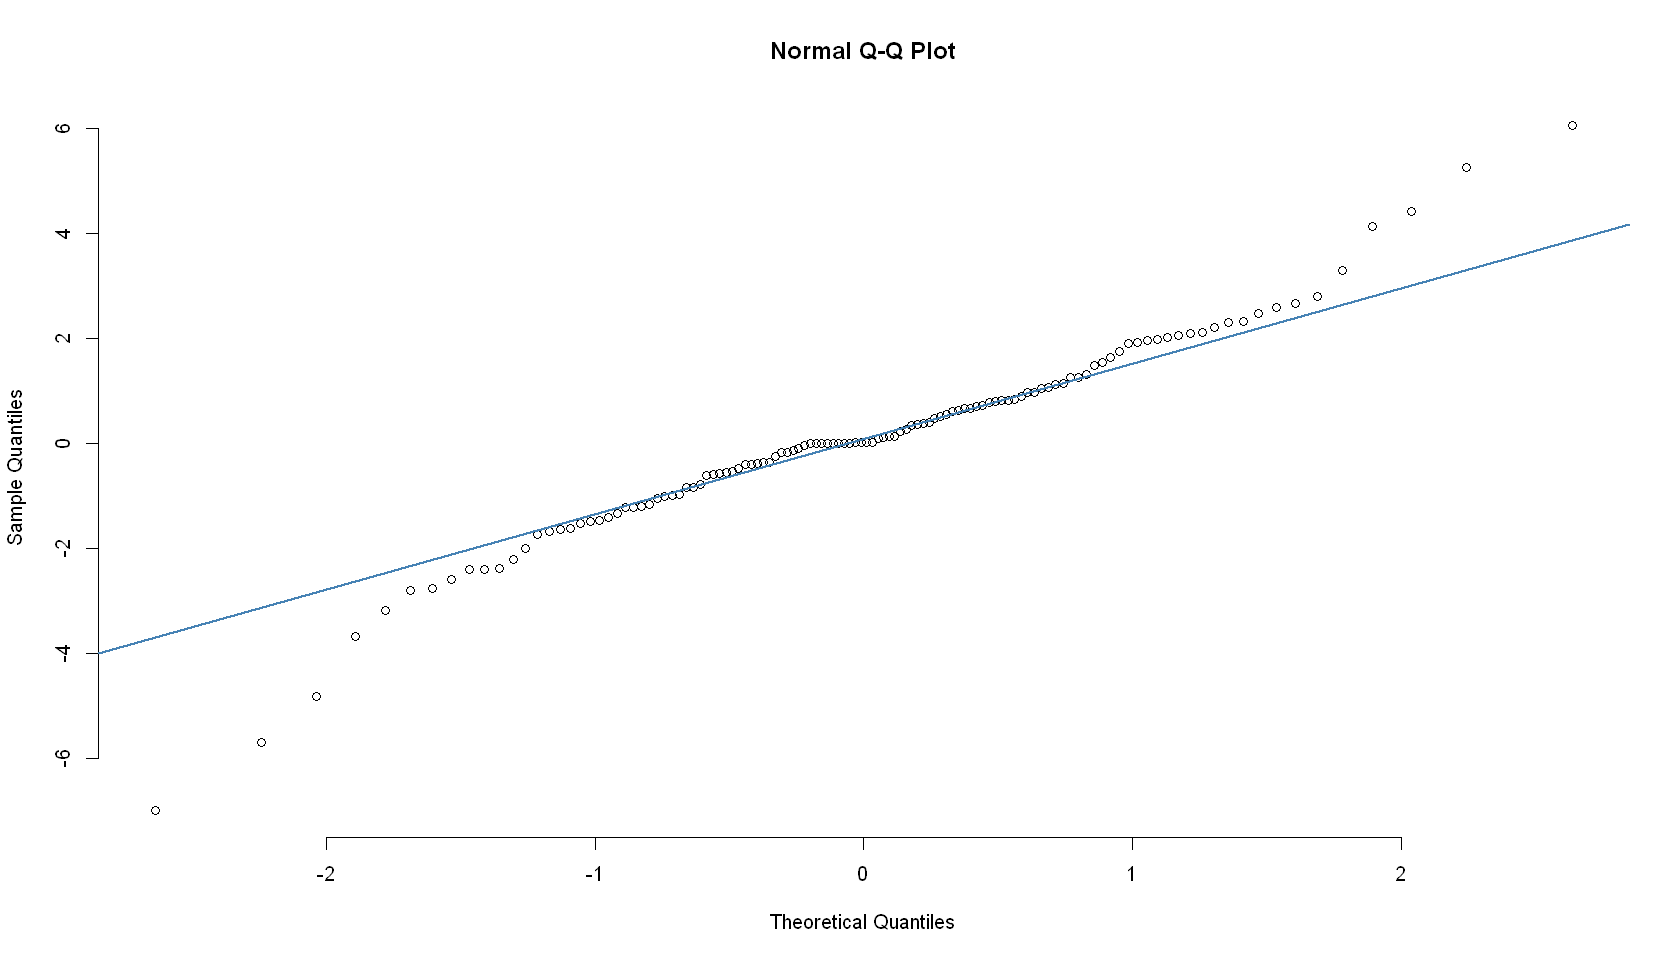

In [75]:
qqnorm(mdl$residuals, pch=1, frame=FALSE)
qqline(mdl$residuals, col="steelblue", lwd=2)
shapiro.test(mdl$residuals)

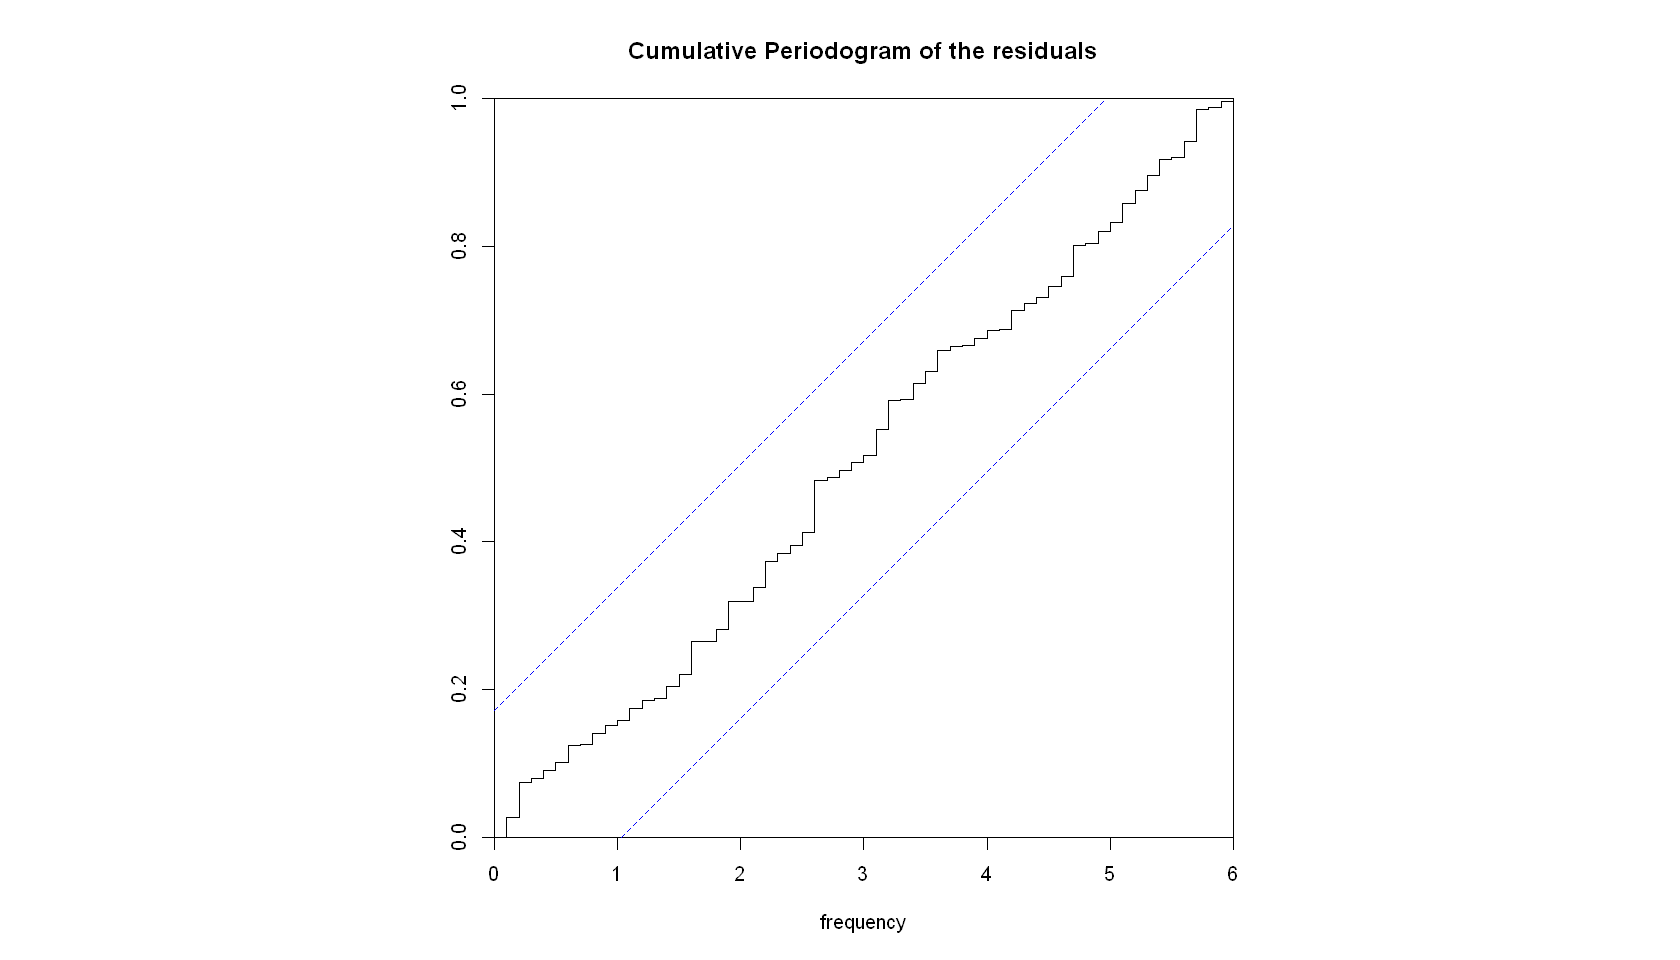

In [76]:
cpgram(mdl$residuals, main="Cumulative Periodogram of the residuals")

# Forecasting

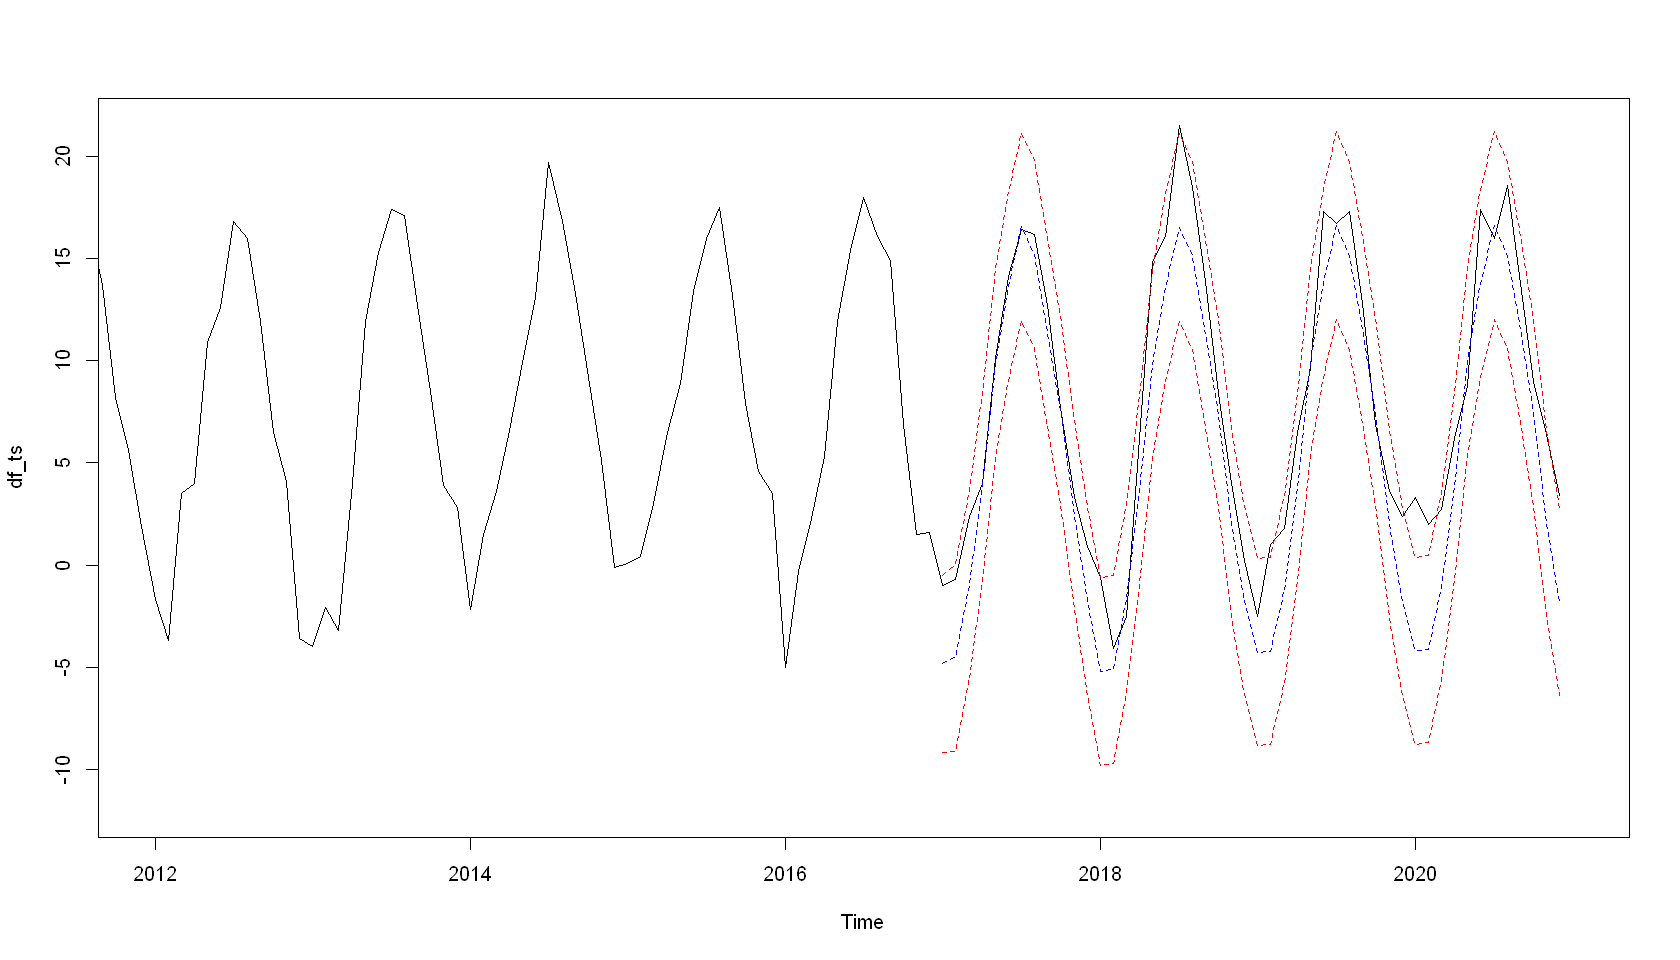

In [77]:
# Forecasting

mdl <- arima(train, order = c(2, 0, 1), seasonal=list(order=c(2,1,1)))
pred <- predict(mdl, n.ahead=48)
ts.plot(df_ts, xlim= c(2012, 2021))

points(pred$pred, type="l", col="blue", lty=2)
lines(pred$pred+2*pred$se, col="red", lty=2)
lines(pred$pred-2*pred$se, col="red", lty=2)

In [27]:
mdl

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"



Call:
arima(x = train, order = c(2, 0, 1), seasonal = list(order = c(2, 1, 1)))

Coefficients:
         ar1      ar2      ma1     sar1     sar2     sma1
      1.3179  -0.3184  -0.9794  -0.0055  -0.0115  -0.9814
s.e.  0.0298   0.0298   0.0167   0.0375      NaN   0.0312

sigma^2 estimated as 3.645:  log likelihood = -909.68,  aic = 1833.36

# Further improvements

A GARCH model would capture the conditional variance and might give better result than ARIMA could.